## Measuring the Overton Window

One of the chapters in *Probably Overthinking It* is about the [Overton window](https://en.wikipedia.org/wiki/Overton_window).
While working on that chapter, I used a bit of Bayesian inference that is too technical to explain in the book. So I'll explain it here.

If you would like to get infrequent email announcements about the book, please [sign up for my mailing list](http://eepurl.com/h0nfbX).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/overton_irt.ipynb)

## Imports and Function Definitions

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.7):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

<IPython.core.display.Javascript object>

In [3]:
def plot_series_lowess(series, color, plot_series=False, frac=0.7, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

<IPython.core.display.Javascript object>

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

<IPython.core.display.Javascript object>

## Read the Data

In [49]:
from os.path import basename, exists
from pathlib import Path


def download(url, data_dir="../data"):
    filename = Path(data_dir) / basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

<IPython.core.display.Javascript object>

In [50]:
!mkdir -p ../data

<IPython.core.display.Javascript object>

In [51]:
filename = download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/gss_simpson.hdf"
)

<IPython.core.display.Javascript object>

In [52]:
gss = pd.read_hdf(filename, "gss").dropna(subset=["cohort10"])
gss.shape

(68075, 214)

<IPython.core.display.Javascript object>

## Quantifying Political Beliefs

One of my goals in the chapter is to quantify liberal and conservative beliefs and see how they have changed over time, using data from the [General Social Survey](https://www.norc.org/Research/Projects/Pages/general-social-survey.aspx) (GSS).
So, how do we classify beliefs as conservative or liberal? And then, how do we track those beliefs over time?

To answer the first question, I started with a list of about 120 core GSS questions that ask about political beliefs, broadly defined.
For each question, I identified the responses that were chosen more often by people who consider themselves conservative.

Then, I searched for questions with the biggest differences between the responses of liberals and conservatives. From those, I curated a list of fifteen questions that cover a diverse set of topics, with preference for questions that were asked most frequently over the years of the survey.

The topics that made the list are not surprising. They include economic issues like public spending on welfare and the environment; policy issues like the legality of guns, drugs, and pornography; as well as questions related to sex education and prayer in schools, capital punishment, assisted suicide, and (of course) abortion. The list also includes three of the questions we looked at in previous sections, related to open housing laws, women in politics, and homosexuality.

For the current purpose, we are not concerned with the wording of the questions; we only need to know that liberals and conservatives give different answers. But if you are curious, I'll put the questions at the end of this post.

To classify respondents, I'll use responses to the following question:

> I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

The points on the scale are Extremely liberal, Liberal, and Slightly liberal; Moderate;	Slightly conservative, Conservative, and Extremely conservative.

I'll lump the first three points into "Liberal" and the last three into "Conservative", which makes the number of groups manageable and, it turns out, roughly equal in size.
Here's how many respondents are in each group.

In [8]:
gss["polviews3"].value_counts()

Moderate        22674
Conservative    20151
Liberal         16006
Name: polviews3, dtype: int64

<IPython.core.display.Javascript object>

Here are the variable names and the responses chosen more often by conservatives.
Most of the questions are binary, but some allow a range of responses.

In [9]:
convervative_values = {
    "abany": [2],
    "homosex": [1, 2, 3],
    "premarsx": [1, 2, 3],
    "prayer": [2],
    "natfare": [3],
    "grass": [2],
    "natenvir": [2, 3],  # about right or too much
    "divlaw": [2],
    "cappun": [1],
    "racopen": [1],
    "letdie1": [2],
    "fepol": [1],
    "gunlaw": [2],
    "sexeduc": [2],
    "pornlaw": [1],
}

<IPython.core.display.Javascript object>

In [10]:
order = [
    "homosex",
    "cappun",
    "grass",
    "abany",
    "prayer",
    "premarsx",
    "divlaw",
    "natfare",
    "natenvir",
    "pornlaw",
    "racopen",
    "letdie1",
    "fepol",
    "gunlaw",
    "sexeduc",
]

<IPython.core.display.Javascript object>

I'll extract the answers to the fifteen questions into a `DataFrame` of boolean values, `True` if the respondent chose a conservative response, `False` if they didn't and `NaN` if they were not asked the question or didn't answer.

In [11]:
questions = pd.DataFrame(dtype=int)

for varname in order:
    questions[varname] = gss[varname].isin(convervative_values[varname])
    null = gss[varname].isna()
    questions.loc[null, varname] = np.nan

<IPython.core.display.Javascript object>

For each questions, here's the fraction of all respondents who chose a conservative response.

In [12]:
questions.mean().sort_values()

sexeduc     0.122969
gunlaw      0.247280
fepol       0.287992
letdie1     0.316496
pornlaw     0.367675
racopen     0.380868
natenvir    0.382537
natfare     0.473809
divlaw      0.491176
premarsx    0.545764
abany       0.588234
prayer      0.594343
grass       0.690151
cappun      0.706214
homosex     0.715237
dtype: float64

<IPython.core.display.Javascript object>

Now let's group the respondents by political label and compute the percentage of conservative responses in each.

In [13]:
augmented = pd.concat([questions, gss["polviews3"]], axis=1)
table = augmented.groupby("polviews3").mean().transpose() * 100
table

polviews3,Conservative,Liberal,Moderate
homosex,81.451613,54.716981,71.971581
cappun,79.277404,57.482234,72.702286
grass,76.629890,55.201863,68.811501
abany,69.364351,42.418054,59.065954
prayer,66.934087,44.098649,62.514552
premarsx,65.097607,39.699676,52.196638
divlaw,58.520050,38.285834,48.083854
natfare,58.065690,34.331875,47.990982
natenvir,48.395992,26.128530,37.341671
pornlaw,44.122149,25.163528,35.973006


<IPython.core.display.Javascript object>

Here's a short text description for each question.

In [14]:
issue_dict = {
    "abany": "Abortion",
    "homosex": "Homosexuality",
    "premarsx": "Premarital sex",
    "prayer": "School prayer",
    "natfare": "Welfare spending",
    "grass": "Legal cannabis",
    "natenvir": "Environment",
    "divlaw": "Divorce",
    "cappun": "Capital punishment",
    "racopen": "Fair housing law",
    "letdie1": "Assisted suicide",
    "fepol": "Women in politics",
    "gunlaw": "Gun law",
    "sexeduc": "Sex education",
    "pornlaw": "Pornography",
}

issue_names = pd.Series(issue_dict)[order].values

<IPython.core.display.Javascript object>

The following figure shows, for each question, the percentage of liberals, moderates, and conservatives who chose one of the conservative responses.

In [15]:
polview_names = ["Conservative", "Moderate", "Liberal"]

muted = sns.color_palette("muted", 5)
polview_map = dict(zip(polview_names, [muted[3], muted[4], muted[0]]))
marker_map = dict(zip(polview_names, ["s", "^", "o"]))
line_map = dict(zip(polview_names, ["--", "-.", ":"]))

<IPython.core.display.Javascript object>

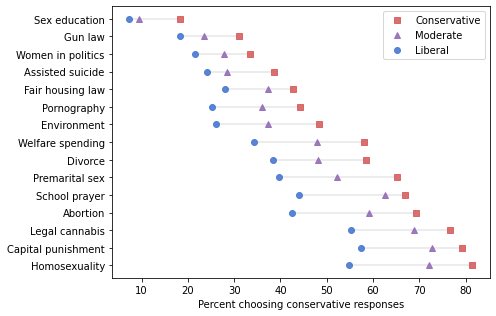

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(7, 4.5))
plt.hlines(
    issue_names,
    table["Liberal"],
    table["Conservative"],
    color="gray",
    alpha=0.2,
)

for polviews, color in polview_map.items():
    x = table[polviews]
    marker = marker_map[polviews]
    plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polviews)

decorate(xlabel="Percent choosing conservative responses")

Not surprisingly, conservatives are more likely than liberals to choose conservative responses, and moderates are somewhere in the middle.
The differences between the groups range from 11 to 27 percentage points.

In [17]:
(table["Conservative"] - table["Liberal"]).sort_values()

sexeduc     10.988434
fepol       11.861161
gunlaw      12.685055
letdie1     14.488009
racopen     14.506078
pornlaw     18.958621
divlaw      20.234216
grass       21.428026
cappun      21.795171
natenvir    22.267462
prayer      22.835438
natfare     23.733815
premarsx    25.397931
homosex     26.734632
abany       26.946298
dtype: float64

<IPython.core.display.Javascript object>

These results include respondents over the interval from 1973 to 2021, so they are not a snapshot of recent conditions.
Rather, they show the issues that have distinguished conservatives from liberals over the last 50 years.

## Estimating Conservatism

Now that we've chosen questions that distinguish liberals and conservatives, the next step is to estimate the conservatism of each respondent.
If all respondents answered all of the questions, this would be relatively easy, but they didn't.

Some were surveyed before a particular question was added to the survey or after it was removed.
Also, in some years respondents were randomly assigned a "ballot" with subset of the questions.
Finally, a small percentage of respondents refuse to answer some questions, or say "I don't know".

The following figure shows the distribution of the number of questions answered.

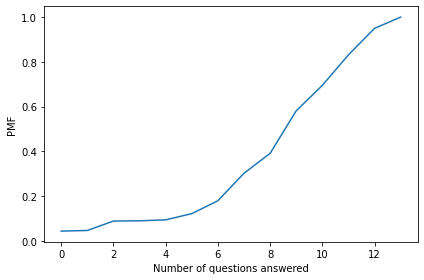

<IPython.core.display.Javascript object>

In [18]:
from empiricaldist import Cdf

answered = questions.notna().sum(axis=1)
Cdf.from_seq(answered).plot()

decorate(xlabel="Number of questions answered", ylabel="PMF")

Most respondents answered at least 5 questions, which is enough to get a sense of how conservative they are.
But there's another problem: some questions are "easier" than others.
For some questions a majority choose a conservative response; for others it's a small minority.
If two people answer a different subject of the questions, we can't compare them directly.

However, this is exactly the problem [item response theory](https://en.wikipedia.org/wiki/Item_response_theory) (IRT) is intended to solve!
The fundamental assumptions of IRT are:

* Each question has some level of difficulty, $d_j$.

* Each respondent has some level of efficacy, $e_i$.

* The probability that a respondent gets a question right is a function of $d_j$ and $e_i$.

In this context, a question is "difficult" if few people choose a conservative response and "easy" if many do.
And if a respondent has high "efficacy", that means they have a high tendency to choose conservative responses.

In one simple version of IRT, if a person with efficacy $e_i$ answers a question with difficulty $d_j$, the probability they get it right is 

$$ \operatorname{expit}~(e_i - d_j)$$

Efficacy and difficulty are latent attributes; that is, we don't observe them directly. Rather, we infer them from data.
In some models, we use a large dataset to estimate $e$ for each respondent and $d$ for each question simultaneously.
For this problem, that would be impractical, so I'll use a shortcut: I'll use the data to assign a difficulty to each question.
Then I can estimate the efficacy of each respondent independently, which is simple and fast.

For each question, we know the proportion of respondents who chose a conservative response, which I'll call $p_j$.

To assign a difficulty to each question, I'll use this heuristic: the difficulty of a question, $d_j$, is the value so that if the question is answered by someone with $e=0$, the probability they get it "right" is $p_j$.
This heuristic leads to the assignment:

$$ d_j = -\operatorname{logit}~(p_j) $$

The following figure shows these values for the fifteen questions.

In [19]:
from scipy.special import logit

difficulty = -logit(questions.mean())
difficulty

homosex    -0.920956
cappun     -0.877069
grass      -0.800827
abany      -0.356669
prayer     -0.381949
premarsx   -0.183572
divlaw      0.035300
natfare     0.104861
natenvir    0.478795
pornlaw     0.542204
racopen     0.485867
letdie1     0.769923
fepol       0.905155
gunlaw      1.113172
sexeduc     1.964611
dtype: float64

<IPython.core.display.Javascript object>

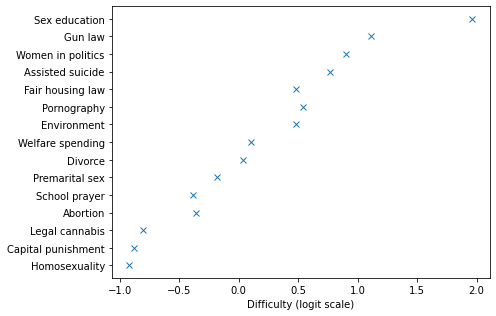

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(7, 4.5))

plt.plot(difficulty, issue_names, "x")

decorate(xlabel="Difficulty (logit scale)")

Where $p_j$ is low, $d_j$ is high.
The range of these values, by itself, doesn't mean very much; what matters is how the values of $e$ and $d$ relate to each other.

Given the assigned difficulties, we can identify a useful range of values for efficacy.
The following figure shows the range I used, from -6 to 6.

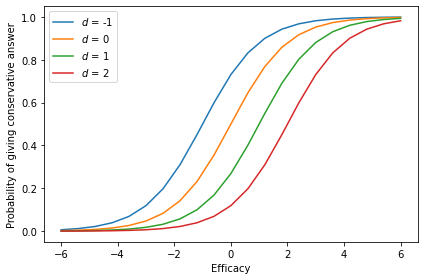

<IPython.core.display.Javascript object>

In [21]:
from scipy.special import expit

es = np.linspace(-6, 6, 21)

for d in [-1, 0, 1, 2]:
    p = expit(es - d)
    plt.plot(es, p, label=f"$d$ = {d}")

decorate(xlabel="Efficacy", ylabel="Probability of giving conservative answer")

Someone with efficacy -6 is very liberal; their probability of choosing a conservative response is nearly 0, even for the easiest question ($d = -1$).
Someone with efficacy 6 is very conservative; their probability of choosing a conservative responses is nearly 1, even for the most difficulty question ($d = 2$).

Given the difficulties of the questions, we can compute the expected number of conservative responses at each level of efficacy.

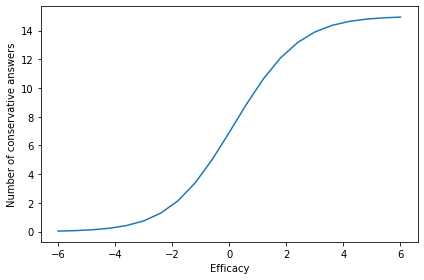

<IPython.core.display.Javascript object>

In [22]:
E, D = np.meshgrid(es, difficulty)
P = expit(E - D)
ns = P.sum(axis=0)
plt.plot(es, ns)

decorate(xlabel="Efficacy", ylabel="Number of conservative answers")

Someone with efficacy 0 is expected to give about 7 conservative responses our of 15 questions.

## Estimating Conservatism

Now let's see how we can estimate $e_i$ for a respondent based on their answers.
I'll start with a weakly informative prior that suggest people are more likely to be in the middle and less likely to be at the extremes.

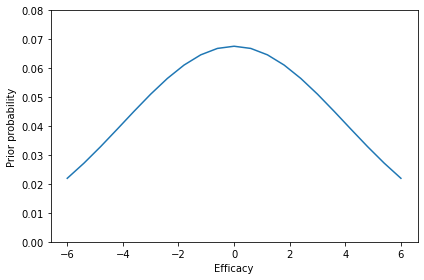

<IPython.core.display.Javascript object>

In [23]:
from scipy.stats import norm
from empiricaldist import Pmf

ps = norm.pdf(es, 0, 4)
prior = Pmf(ps, es)
prior.normalize()
prior.plot()
decorate(xlabel="Efficacy", ylabel="Prior probability", ylim=[0, 0.08])

To demonstrate the estimation process, I'll use the responses from an arbitrarily-chosen respondent.

In [24]:
row = questions.iloc[5000]
row

homosex       NaN
cappun       True
grass       False
abany         NaN
prayer      False
premarsx     True
divlaw       True
natfare     False
natenvir     True
pornlaw     False
racopen      True
letdie1       NaN
fepol       False
gunlaw       True
sexeduc     False
Name: 5034, dtype: object

<IPython.core.display.Javascript object>

To compute the likelihood of the data, I'll make an array, `P`, with one row per question and one column for each hypothetical value of $e$.
Each element of `P` is the probability that someone with a given efficacy gets a given question "right".

In [25]:
E, D = np.meshgrid(es, difficulty)
P = expit(E - D)
Q = 1 - P
Q.shape

(15, 21)

<IPython.core.display.Javascript object>

`Q` is the complement of `P`; each element is the probability that someone with a given efficacy gets a given question "wrong".

Now, for a given row of responses we can compute the likelihood of the data.

In [26]:
# compute the likelihoods of the conservative responses
index1 = np.nonzero(row.values == True)
like1 = P[index1]

# compute the likelihoods of the non-conservative responses
index2 = np.nonzero(row.values == False)
like2 = Q[index2]

# multiply them all together
like = np.vstack([like1, like2]).prod(axis=0)

<IPython.core.display.Javascript object>

`like` is contains the likelihood of the data for each value of $e$.

To do the Bayesian update, we multiply the prior by the likelihood and normalize.
I'm using `ns` as the index of the posterior PMF, so the results are expressed in terms of the number of conservative responses, which is easier to interpret than efficacy.

In [27]:
posterior = Pmf(prior.values * like, ns)
posterior.normalize()
posterior.mean(), posterior.std()

(7.75764821546671, 1.9344763248098429)

<IPython.core.display.Javascript object>

Here's what the posterior distribution looks like.

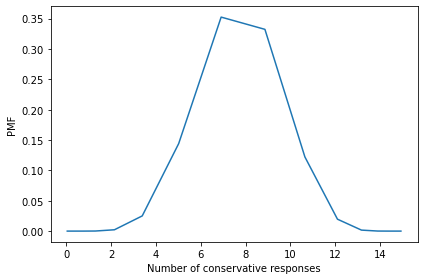

<IPython.core.display.Javascript object>

In [28]:
posterior.plot()
decorate(xlabel="Number of conservative responses", ylabel="PMF")

The posterior mean is about 7.8 questions, but the spread of the distribution is wide, indicating that we are still uncertain about how conservative this respondent is.

Here's the same code in a function.

In [29]:
def estimate_conservatism(row):
    """Compute the posterior distribution of conservatism.

    row: pd.Series of True, False, or NaN, one per question

    returns: posterior mean and std of estimated conservatism
    """
    index1 = np.nonzero(row.values == True)
    like1 = P[index1]

    index2 = np.nonzero(row.values == False)
    like2 = Q[index2]

    like = np.vstack([like1, like2]).prod(axis=0)

    posterior = Pmf(prior.values * like, ns)
    posterior.normalize()

    return posterior.mean(), posterior.std()

<IPython.core.display.Javascript object>

So we can apply it to the whole dataset row-wise.

In [30]:
%time res = questions.apply(estimate_conservatism, axis=1, result_type='expand')
mean, std = np.transpose(res.values)

CPU times: user 26.6 s, sys: 196 ms, total: 26.8 s
Wall time: 26.6 s


<IPython.core.display.Javascript object>

Doing the calculation one row at a time takes longer than I'd like. So before we look at the results, let's speed it up.

## Array Operations For the Win

To eliminate the `for` loop, we can compute the results for all respondents
with a single 3-D array: one row for each respondent, one column for each question,
one page for each hypothetical value of $e$.

In [31]:
n, m = questions.shape
size = n, m, len(es)
res = np.empty(size)
res.shape

(68075, 15, 21)

<IPython.core.display.Javascript object>

Now we can fill the array with the likelihoods of conservative and non-conservative responses; where there's a `NaN`, we fill in a sequence of `1`s.

In [32]:
a = questions.fillna(2).astype(int).values
ii, jj = np.nonzero(a == 0)
res[ii, jj, :] = Q[jj]
ii, jj = np.nonzero(a == 1)
res[ii, jj, :] = P[jj]
ii, jj = np.nonzero(a == 2)
res[ii, jj, :] = 1

<IPython.core.display.Javascript object>

Multiplying along the rows gives the likelihood of each row of responses, which we multiply by the prior probabilities:

In [33]:
product = res.prod(axis=1) * prior.values
product.shape

(68075, 21)

<IPython.core.display.Javascript object>

Finally, we normalize the rows to get a posterior distribution for each respondent.


In [34]:
posterior = product / product.sum(axis=1)[:, None]
posterior.shape

(68075, 21)

<IPython.core.display.Javascript object>

The estimated conservatism for each respondent is the mean of the posterior distribution.

In [35]:
con = (posterior * ns).sum(axis=1)
con.shape

(68075,)

<IPython.core.display.Javascript object>

We'll also compute the standard deviation of the posterior distribution, which I'll use to remove respondents who did not answer enough questions.

In [36]:
deviations = ns - con[:, None]
var_con = (posterior * deviations ** 2).sum(axis=1)
std_con = np.sqrt(var_con)
std_con.shape

(68075,)

<IPython.core.display.Javascript object>

We can confirm that the results from the array operation is the same as the row-wise calculation.

In [37]:
np.allclose(con, mean), np.allclose(std_con, std)

(True, True)

<IPython.core.display.Javascript object>

Here's what the distribution of estimates looks like among the respondents.

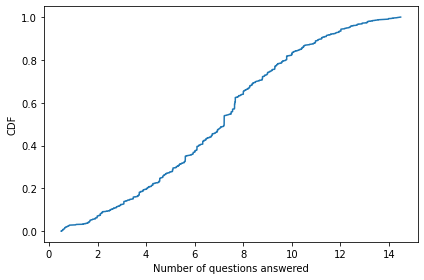

<IPython.core.display.Javascript object>

In [38]:
from empiricaldist import Cdf

Cdf.from_seq(con).plot()
decorate(xlabel="Number of questions answered", ylabel="CDF")

In [39]:
con.mean()

6.945564025317626

<IPython.core.display.Javascript object>

The distribution is roughly Gaussian, with a mean near 7 questions.
Here's the distribution of standard deviations.

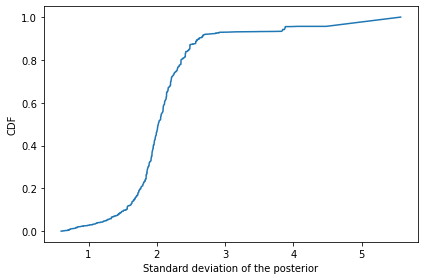

<IPython.core.display.Javascript object>

In [40]:
Cdf.from_seq(std_con).plot()

decorate(xlabel="Standard deviation of the posterior", ylabel="CDF")

For most respondents (about 63,000 out of 68,000) we have enough data to estimate the number of conservative responses with standard deviation less than 3.

In [41]:
gss["conservatism"] = pd.Series(con, gss.index)
gss.loc[std_con > 3, "conservatism"] = np.nan
gss["conservatism"].describe()

count    63269.000000
mean         6.911971
std          3.251234
min          0.500713
25%          4.558568
50%          6.933004
75%          9.295529
max         14.477513
Name: conservatism, dtype: float64

<IPython.core.display.Javascript object>

## Conservatism Over Time

The following figure shows the average of these estimates for each years of the survey.

In [53]:
series = gss.groupby("year")["conservatism"].mean()

KeyError: 'Column not found: conservatism'

<IPython.core.display.Javascript object>

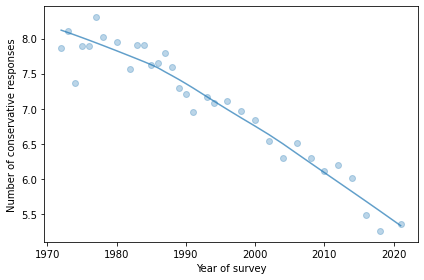

<IPython.core.display.Javascript object>

In [43]:
plot_series_lowess(series, plot_series=True, color="C0", alpha=0.7, label="")
decorate(xlabel="Year of survey", ylabel="Number of conservative responses")

The prevalence of conservative responses has decreased over the last 50 years.
In 1973, the average respondent chose a conservative response to 8.1 out of 15 questions; in 2021, it had fallen to 5.3.

There is no evidence that this trend has slowed or reversed recently.
In 2012 and 2014, it might have been above the long-term trend; in 2016 and 2018, it was below it.
And the most recent data, from 2021, is exactly on pace.

## Are We Polarized?

In current commentary, it is often taken for granted that politics in the U.S. have become more polarized.
If we take that to mean that conservatives are becoming more conservative, and liberals more liberal, that turns out not to be true.

The following figure shows conservatism over time, grouped by political label.

In [44]:
table = gss.pivot_table(index="year", columns="polviews3", values="conservatism")

<IPython.core.display.Javascript object>

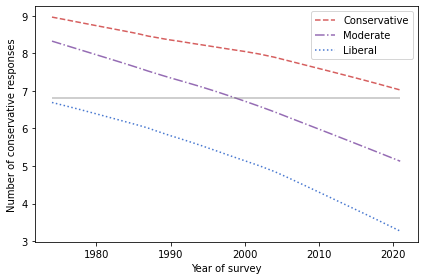

<IPython.core.display.Javascript object>

In [45]:
columns = ["Conservative", "Moderate", "Liberal"]
for column in columns:
    plot_series_lowess(table[column], ls=line_map[column], color=polview_map[column])

plt.hlines(6.8, 1974, 2021, color="gray", alpha=0.5)
decorate(xlabel="Year of survey", ylabel="Number of conservative responses")

In [46]:
for column, series in table.iteritems():
    smooth = make_lowess(series)
    diff = smooth.iloc[-1] - smooth.iloc[1]
    print(column, diff)

Conservative -1.9034502158899897
Liberal -3.3772592744433676
Moderate -3.137751450771902


<IPython.core.display.Javascript object>

All three groups have become more liberal; however, the slopes of the lines are somewhat different.
Over this interval, conservatives have become more liberal by about 1.9 expected responses, moderates by 3.1, and liberals by 3.4.
That's a kind of polarization in the sense that the groups moved farther apart, but not in the sense that they are moving in opposite directions.


In the previous figure, the horizontal line is at 6.8 responses, which was the expected level of conservatism in 1974 among people who called themselves liberal.

So, suppose you take a time machine back to 1974, find an average liberal, and bring them to the turn of the millennium.
Based on their responses to the fifteen questions, they would be indistinguishable from the average moderate in 2000.

And if you bring them to 2021, their quaint 1970s liberalism would be almost as conservative as the average conservative.

In [47]:
make_lowess(table["Moderate"])[2000]

6.728983375512334

<IPython.core.display.Javascript object>

In [48]:
make_lowess(table["Conservative"])[2021]

7.025869206028217

<IPython.core.display.Javascript object>

## Appendix: The Fifteen Questions

This appendix provides the wording of the fifteen questions from the General Social Survey that most distinguish liberals and conservatives, identified by topic and the GSS variable name.

1. Homosexuality (homosex): What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

2. Capital punishment (cappun): Do you favor or oppose the death penalty for persons convicted of murder?

3. Legal cannabis (grass): Do you think the use of marijuana should be made legal or not?

4. Abortion (abany): Please tell me whether or not you think it should be possible for a pregnant woman to obtain a legal abortion if the woman wants it for any reason?

5. Prayer in public schools (prayer): The United States Supreme Court has ruled that no state or local government may require the reading of the Lord's Prayer or Bible verses in public schools. What are your views on this--do you approve or disapprove of the court ruling?

6. Premarital sex (premarsx): There's been a lot of discussion about the way morals and attitudes about sex are changing in this country. If a man and woman have sex relations before marriage, do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

7. Divorce (divlaw): Should divorce in this country be easier or more difficult to obtain than it is now?

8. Spending on welfare (natfare) and the environment (natenvir): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount.
  * Welfare

  * Improving and protecting the environment

9. Pornography (pornlaw): Which of these statements comes closest to your feelings about pornography laws? 

  * There should be laws against the distribution of pornography whatever the age.

  * There should be laws against the distribution of pornography to persons under 18.

  * There should be no laws forbidding the distribution of pornography.

10. Open housing law (racopen): Suppose there is a community-wide vote on the general housing issue. There are two possible laws to vote on:

  * One law says that a homeowner can decide for himself whom to sell his house to, even if he prefers not to sell to [people of a particular race].

  * The second law says that a homeowner cannot refuse to sell to someone because of their race or color.

    Which law would you vote for? 

11. Assisted suicide (letdie1): When a person has a disease that cannot be cured, do you think Doctors should be allowed by law to end the patient's life by some painless means if the patient and his family request it?

12. Women in politics (fepol): Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women.

13. Gun control (gunlaw): Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

14. Sex education (sexeduc): Would you be for or against sex education in the public schools?